# Transform mask into COSTO .json

In [229]:
import re
from os import listdir, PathLike
from os.path import join
from pipeline.image_handeling.data_utility import load_stack
from skimage.measure import find_contours, regionprops_table
from numpyencoder import NumpyEncoder
import json

def mask_to_json(mask_fold_path: PathLike, save_path: PathLike, channel:str)->None:
  """Function that converts .tif labeled masks from np.array stacks into COCO .json format files.
  Saves the file into the given location.
  Args:
      mask_fold_path (PathLike): Folder of the masks.
      save_path (PathLike): Path where the .json is going to be saved. Must include the filename and the ending ".json".
      channel (string): The channel that should be transformed into .json.
  Returns:
      None, saves the .json into the given location."""
  img_path = []
  for file in sorted(listdir(mask_fold_path)):
      if channel in file:
        img_path.append(join(mask_fold_path,file))
  im_num = re.findall('f\d+', str(img_path))
  max_number = max(int(x[1:]) for x in im_num)
  max_number

  img_stack = load_stack(img_paths=img_path, channels=channel, frame_range=range(max_number), return_2D=True)

  annotations_lst = []
  images_lst = []
  for frame, img in enumerate(img_stack):
    outline_region =regionprops_table(img, properties=('label','bbox','area'))
    frame_name = img_path[frame].rsplit('/',1)[1]
    labels = outline_region['label']
    bbox0 = outline_region['bbox-0']
    bbox1 = outline_region['bbox-1']
    bbox2 = outline_region['bbox-2']
    bbox3 = outline_region['bbox-3']
    area = outline_region['area']

    for i in range(labels.shape[0]):
        label = labels[i]
        segmentation_lst=[]
        regionmask=(img==label)
        coords = find_contours(regionmask)
        for y,x in coords[0]:
            segmentation_lst.append(x+0.5)
            segmentation_lst.append(y+0.5)
        
        annotations_lst.append({'id':label, 
                                'image_id':frame+1,
                                'category_id':1,
                                'segmentation':[segmentation_lst],
                                'area':area[i],
                                'bbox':[bbox0[i], bbox1[i], bbox2[i], bbox3[i]],
                                'iscrowd': 0,
                                'attributes': {'occluded': False}})

    images_lst.append({'id': frame+1,
              'width': img.shape[1],
              'height': img.shape[0],
              'file_name': frame_name,
              'license': 0,
              'flickr_url': '',
              'coco_url': '',
              'date_captured': 0})

  json_dict = {'licenses': [{'name': '', 'id': 0, 'url': ''}],
          'info': {'contributor': '',
            'date_created': '',
            'description': '',
            'url': '',
            'version': '',
            'year': ''},
          'categories': [{'id': 1, 'name': 'Cell', 'supercategory': ''}],
          'images': images_lst,
          'annotations':annotations_lst}

  with open(save_path, "w") as file:
      json.dump(json_dict, file, cls=NumpyEncoder)

In [230]:

mask_folder = '/home/Fabian/ImageData/TrackingTestFiles/NeutrophilTrackingTest/mfap4-mpx_isohypo_2h_WT-MaxIP_s1/Masks_Cellpose'
channel = 'GFP'
savefile = '/home/Fabian/ImageData/Seriestest.json'

mask_to_json(mask_fold_path=mask_folder, save_path=savefile, channel=channel)

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)]


# Reconstruct mask based on COSTO .json

In [231]:
import json
import numpy as np
from skimage.draw import polygon2mask
from os import PathLike

def mask_from_json(path:PathLike)->tuple[list[str],np.array]:
    """Recreates an np.array like stack of masks based on an COCO .json file.
    Return the np.array stack of masks and a list fo the Mask names.
    Args:
        path (PathLike): Path of the .json file to be loaded.
    Returns:
        tuple[list[str],np.array]: List of the image names, np.array containing the loaded masks"""
    file = open(path)
    json_file = json.load(file)

    mask_lst = []
    name_lst = []
    width = json_file['images'][0]['width']
    height = json_file['images'][0]['height']
    annotations = json_file['annotations']
    n_frame = len(json_file['images'])
    mask = np.zeros((n_frame,width,height), dtype='int')
    for images in json_file['images']:
        name_lst.append(images['file_name'])
    for annot in annotations:
        segmentation = annot['segmentation'][0]
        id = int(annot['id'])
        frame_id = int(annot['image_id'])
        coord_lst = []
        for point in range(0, len(segmentation),2):
            coord_lst.append((round(segmentation[point+1]), round(segmentation[point])))
        tempmask =  polygon2mask((width,height),coord_lst)
        tempmask[tempmask!=0] = id
        mask[frame_id-1] = mask[frame_id-1] + tempmask
    mask_lst.append(mask)
    mask_stack = np.squeeze(np.stack(mask_lst))
    return name_lst, mask_stack

In [232]:
path = '/home/Fabian/ImageData/instances_Series.json'
name_lst, mask_stack = mask_from_json(path)

# Play area

In [61]:
import numpy as np
from tifffile import imwrite
from os import walk
from os.path import join
from concurrent.futures import ThreadPoolExecutor

In [ ]:
folder_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Laserwound/c1147x1382_003-MaxIP_s2/Masks_Cellpose'

In [68]:
for root, dirs, files in walk(folder_path):
    for file in files:
        if file.endswith('.npy'):            
            npy = np.load(join(root, file), allow_pickle=True).item()
            filename = npy['filename']
            mask = npy['masks']
            imwrite(filename, mask)

UnpicklingError: pickle data was truncated

In [231]:
import pandas as pd
import numpy as np
import torch
from tifffile import imread
from matplotlib.pyplot import imshow

In [230]:
img_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose/RFP_s01_f0001_z0001.tif'
mask = imread(img_path)

In [253]:
pred = mask.copy()
pred[pred==2] = 1
pred_copy = pred.copy()
mask_where = np.ones_like(pred)

In [258]:
val = 1
true_id = 100


In [259]:

mask_val = (pred_copy == val).copy()
mask_curr = np.logical_and(mask_val, mask_where)
pred_copy[mask_curr] = true_id
mask_where = np.logical_and(np.logical_not(mask_val), mask_where)

In [260]:
np.unique(mask_val)

array([False,  True])

In [261]:
np.unique(mask_where)

array([False,  True])

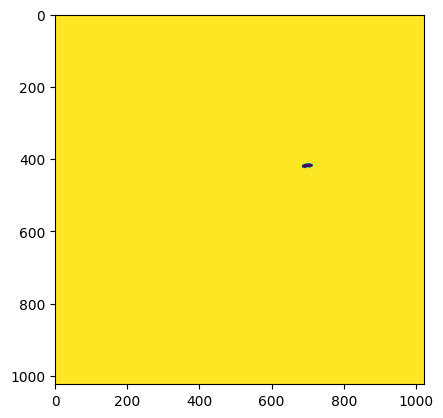

In [262]:
imshow(mask_where)

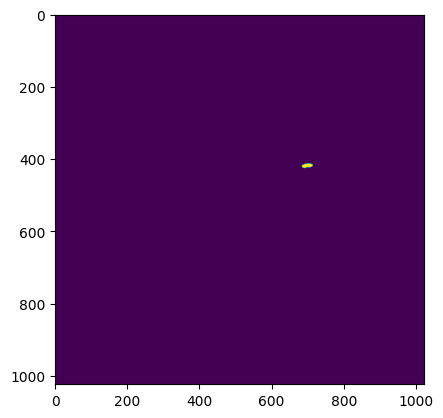

In [263]:
imshow(mask_curr)

In [247]:
print(np.unique(mask_curr))
print(np.unique(mask_val))

[False  True]
[False  True]


In [179]:
csv_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/gnn_files/all_data_df.csv'
df = pd.read_csv(csv_path)
pytorch_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/gnn_files/pytorch_geometric_data.pt'
edge_index = torch.load(pytorch_path).edge_index
output_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/gnn_files/raw_output.pt'
output_pred = torch.load(output_path)
outputs = output_pred


In [202]:
decision_threshold = 0

In [212]:
outputs_soft = torch.sigmoid(outputs)
outputs_hard = (outputs_soft > decision_threshold).int()
connected_indices = edge_index[:, outputs_hard.bool()]

ind_place = np.argwhere(connected_indices[0, :] == 2)

In [213]:
ind_place

tensor([[2, 3]])

In [ ]:
np.unique(outputs_soft)

In [100]:
def fill_first_frame(cell_starts):
    cols = ["child_id", "parent_id", "start_frame"]
    df_parent = pd.DataFrame(index=range(len(cell_starts)), columns=cols)
    df_parent.loc[:, ["start_frame", "parent_id"]] = 0
    df_parent.loc[:, "child_id"] = cell_starts
    return df_parent

In [ ]:
def insert_in_specific_col(all_frames_traject, frame_ind, curr_node, next_node):
    if curr_node in all_frames_traject[frame_ind, :]:
        flag = 0
        ind_place = np.argwhere(all_frames_traject[frame_ind, :] == curr_node)
        if frame_ind + 1 < all_frames_traject.shape[0]:
            all_frames_traject[frame_ind + 1, ind_place] = next_node
    else:
        flag = 1
        ind_place = np.argwhere(all_frames_traject[frame_ind, :] == -2)
        while ind_place.size == 0:
            new_col = -2 * np.ones((all_frames_traject.shape[0], 1), dtype=all_frames_traject.dtype)
            all_frames_traject = np.append(all_frames_traject, new_col, axis=1)
            ind_place = np.argwhere(all_frames_traject[frame_ind, :] == -2)
        ind_place = ind_place.min()
        all_frames_traject[frame_ind, ind_place] = curr_node
        if frame_ind + 1 < all_frames_traject.shape[0]:
            all_frames_traject[frame_ind + 1, ind_place] = next_node
    return flag, all_frames_traject

In [205]:
connected_indices = edge_index[:, outputs_hard.bool()]

In [209]:
connected_indices[0, :]

tensor([    0,     1,     2,  ..., 12506, 12507, 12508])

In [ ]:
outputs_soft = torch.sigmoid(outputs)
outputs_hard = (outputs_soft > decision_threshold).int()


flag_id0_terminate = False
# extract values from arguments
connected_indices = edge_index[:, outputs_hard.bool()]


# find number of frames for iterations
frame_nums, counts = np.unique(df.frame_num, return_counts=True)
all_frames_traject = np.zeros((frame_nums.shape[0], counts.max())) #crearing matrix with shape (rows=frames, column=max num of label in frame)

# intialize the matrix with -2 meaning empty cell, -1 means end of trajectory,
# other value means the number of node in the graph
all_frames_traject[:, :] = -2
all_trajectory_dict = {}
str_track = ''
df_parents = []

for frame_ind in frame_nums: 
    nodes_indices = df[df.frame_num==frame_ind].index.values # find the places containing frame_ind
    next_frame_indices = np.array([])
    
    if frame_ind == 0:  # for the first frame, we should fill the first row with node indices
        all_frames_traject[frame_ind, :nodes_indices.shape[0]] = nodes_indices
        df_parents.append(fill_first_frame(nodes_indices))
    
    num_starts = 0
    cell_starts = []
    
    for i in nodes_indices:
        if i in connected_indices[0, :]:
            ind_place = np.argwhere(connected_indices[0, :] == i)
            #check how many potential connections one cell has
            if ind_place.shape[-1] > 1: # if more than one connection is possible:
                next_frame_ind = connected_indices[1, ind_place].numpy().squeeze() #get the ID of the potential cells in the next frame
            
                next_frame = df.loc[next_frame_ind, ["centroid_row", "centroid_col"]].values #getting the centroid position for the potential connection points
                curr_node = df.loc[i, ["centroid_row", "centroid_col"]].values #getting the original centroid

                distance = np.sqrt(((next_frame - curr_node) ** 2).sum(axis=-1)) #get the euclidean distance between the node and the possible cells to connect
                nearest_cell = np.argmin(distance, axis=-1) #get the index of the closest cell
                # add to the array
                next_node_ind = next_frame_ind[nearest_cell]

            elif ind_place.shape[-1] == 1:  # one node in the next frame is connected to current node
                next_node_ind = connected_indices[1, ind_place[0]]
            else:  # no node in the next frame is connected to current node -
                # in this case we end the trajectory
                next_node_ind = -1
        else:
            # we dont find the current node in the edge indices matrix - meaning we dont have a connection
            # for the node - in this case we end the trajectory and the cell
            if i == 0:
                flag_id0_terminate = True
            next_node_ind = -1                
        next_frame_indices = np.append(next_frame_indices, next_node_ind) #add the next node index or -1 for track stop into the next_frame_indices list
        # count the number of starting trajectories
        start, all_frames_traject = insert_in_specific_col(all_frames_traject, frame_ind, i, next_node_ind)
        num_starts += start                
        
                
                
                

In [228]:
frame_ind=0
df_parents = []
nodes_indices = df[df.frame_num==frame_ind].index.values # find the places containing frame_ind
next_frame_indices = np.array([])

if frame_ind == 0:  # for the first frame, we should fill the first row with node indices
    all_frames_traject[frame_ind, :nodes_indices.shape[0]] = nodes_indices
    df_parents.append(fill_first_frame(nodes_indices))
    
    
num_starts = 0
cell_starts = []

i = nodes_indices[2]


if i in connected_indices[0, :]:
    ind_place = np.argwhere(connected_indices[0, :] == i)
    if ind_place.shape[-1] > 1: # if more than one connection is possible:
        next_frame_ind = connected_indices[1, ind_place].numpy().squeeze()
        next_frame = df.loc[next_frame_ind, ["centroid_row", "centroid_col"]].values
        curr_node = df.loc[i, ["centroid_row", "centroid_col"]].values
        print(f'{curr_node=}')
        distance = np.sqrt(((next_frame - curr_node) ** 2).sum(axis=-1))
        print(f'{distance=}')
        nearest_cell = np.argmin(distance, axis=-1)
        print(f'{nearest_cell=}')
        next_node_ind = next_frame_ind[nearest_cell]
        print(f'{next_node_ind=}')
next_frame_indices = np.append(next_frame_indices, next_node_ind)
print(f'{next_frame_indices=}')
# count the number of starting trajectories
start, all_frames_traject = self.insert_in_specific_col(all_frames_traject, frame_ind, i, next_node_ind)
num_starts += start    
    

curr_node=array([565., 273.])
distance=array([ 0.        , 66.09841148])
nearest_cell=0
next_node_ind=13
next_frame_indices=array([13.])


In [168]:
def print_value(value, test_list):
    print(value)
    print(test_list)

In [166]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

In [169]:
unique_stuff = np.unique([90,80,700,50,80])
test_list = 'blbla'
partiaprint = partial(print_value, test_list=test_list)

with ThreadPoolExecutor() as executer:
    executer.map(partiaprint, np.unique([90,80,700,50,80]))


50
blbla
80
blbla
90
blbla
700
blbla
